# Trained UniVI model functions Jupyter notebook

Andrew Ashford, Pathways + Omics group, 5/1/2024

This Jupyter notebook file is meant to be a tutorial for our multimodal data integration method - UniVI. The purpose of this particular tutorial is to familiarize the researcher with several of the built-in functions for using our workflow and how to manipulate different parts of a trained model to generate meaningful results.

### Requirements prior to using the workflow

Before using this workflow, we need to use the included manifold_alignment.yml file to create a Conda environment, then install the ipykernel module if not already done. Lastly, we need to use the ipykernel module to generate an environment kernel for use with Jupyter notebooks.

A tutorial on this can be found here:
https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084


### Import modules

In [4]:
# Import the following commonly-used modules
import os
import anndata
import json
import importlib
import scanpy as sc
from pathlib import Path
from anndata import AnnData
from scipy import sparse

# Import the custom UniVI modules
# I have imported these previously like so, where UniVI workflow folder is in the same directory as this notebook
from UniVI import _MMVAE
from UniVI._MMVAE import CrossMap
from UniVI.utilities._evaluate import EvalMap, predict_celltype
from UniVI.utilities._temp import sub_ad, umap_ad, evalmap, create_comb_anndata_to_eval
from UniVI.datasets._anndata import _read_csv_to_adata, subsample_anndata, combine_anndata, split_anndata, PrepAnnDataRNA, PrepAnnDataADT
from UniVI.plotting.plots import heatmap_from_mtx, heatmap_sample_idx, gg_point_pair_embed, gg_point_z_activation, gg_point_feature_active, gg_point_embed, gg_point_overlay


In [5]:
# Specify the location of the trained model object (usually a folder with the model hyperparameters)
# I have included the following trained model using 10x Genomics PBMC Multiome (paired scRNA/scATAC) data.
dirpath_home = './output/5-1-2024/trained_models/PBMC_multiome_batch_size_500_p30_multi_gaussian_z60_l3_l5_m_elbo_mc20_b145_m1_dim_hidden_224_m2_dim_hidden_224_m1_features_2000_m2_features_2000'


## Overview of UniVI model

Now that we have read in modules and specified the directory for the trained model object, we now need to load the object in and learn what each part does/how to navigate the object. Here is an image of the model overview so I can associate what we're doing with different parts of the model.

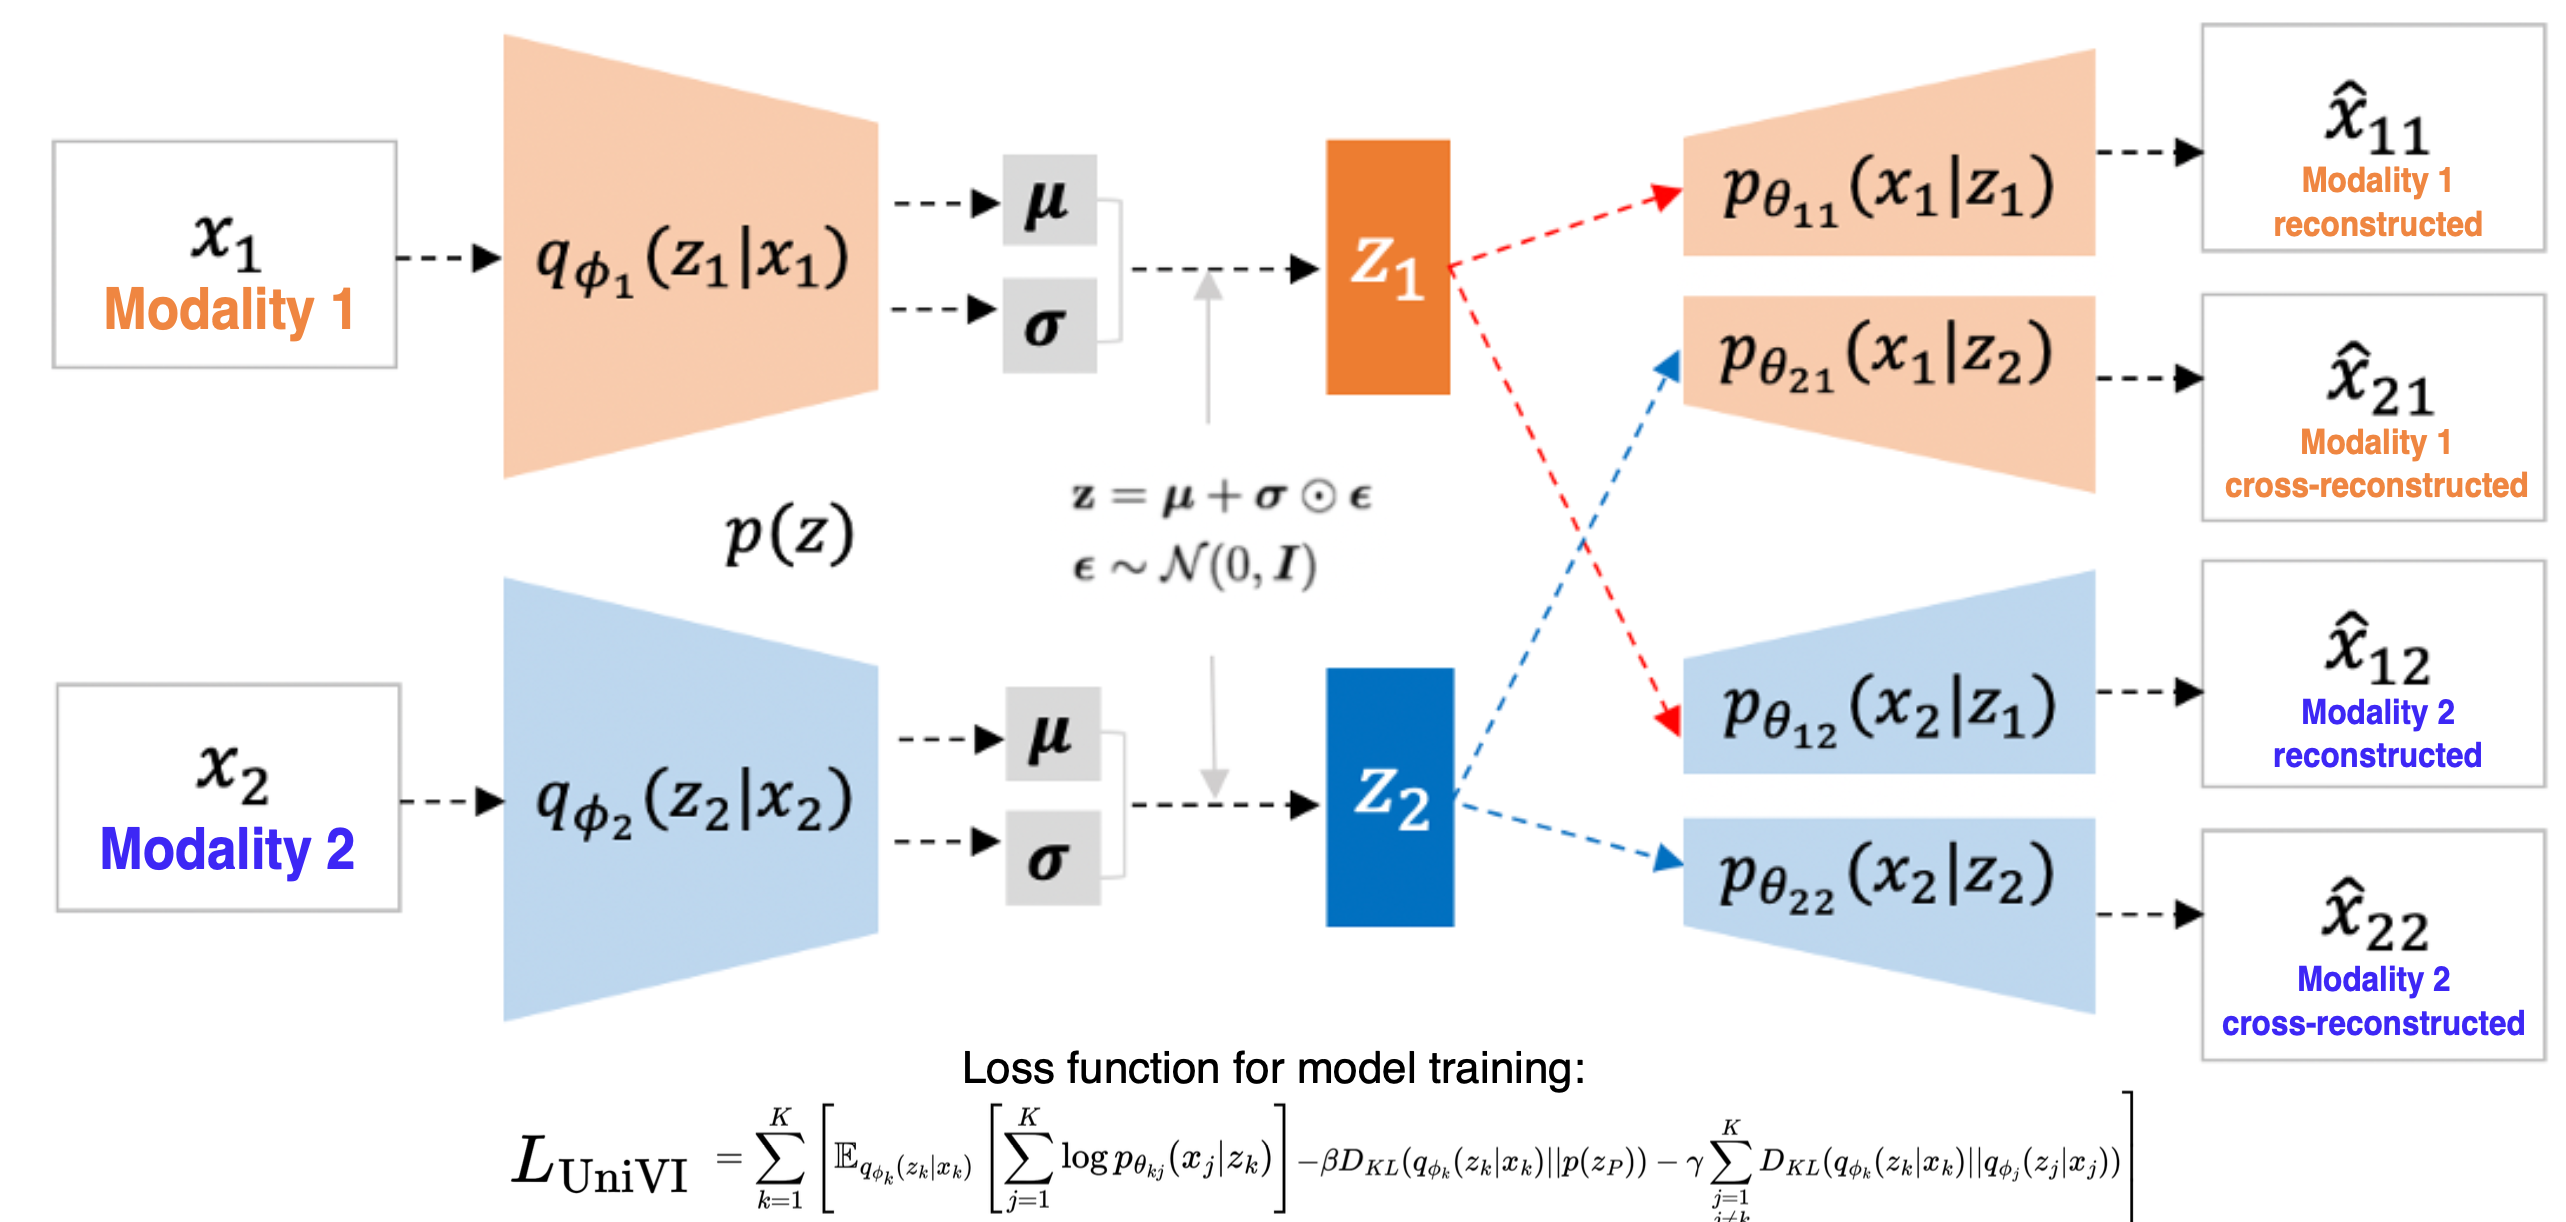

Here is a general legend for the variables in the model:

x1 = single-cell RNA data in this case

x2 = single-cell protein data in this case

The data gets fed through the dual encoder part of the model, represented by:

𝑞𝜙1(𝑧1│𝑥1) = RNA latent feature encoder

𝑞𝜙2(𝑧2│𝑥2) = Protein latent feature encoder

Once encoded, the data is in the form of Z latent feature distributions, these are represented as:
Mu and sigma - ie the mean and standard deviation of all the latent feature space distributions. In this model, they are computationally in the form of distribution tensors that are of size batch x latent feature size. Typically, if we are accessing this space, we will want to use the "update to best epoch" function which I show below. This will allow us to directly sample from these distribution spaces, otherwise, the latent features "Z" and the sampled features from that run.

Next, each modalities' features goes through dual decoders - one that recreates itself, and one that recreates the opposite modality. For example:

𝑝𝜃11(𝑥1|𝑧1) uses the latent dimensions from the RNA encoder and reconstructs the input RNA data

𝑝𝜃21(𝑥1|𝑧2) uses the latent dimensions from the RNA encoder and reconstructs the input protein data

𝑝𝜃12(𝑥2|𝑧1) uses the latent dimensions from the protein encoder and reconstructs the input RNA data

𝑝𝜃22(𝑥2|𝑧2) uses the latent dimensions from the protein encoder and reconstructs the input protein data

In the code below, generally the reconstruction of self is represented as:

adata_rna.layers['xp'] or

adata_protein.layers['xp']

While the cross modal reconstruction is represented as:

adata_rna.layers['xpp'] or

adata_protein.layers['xpp']

Once decoded, the output space are the recreated input features, but a DISTRIBUTION of them, similar to the latent dimensions. The outputs require sampling in order to generate singular results.

## Loading in and accessing different parts of the trained model

In [6]:
# Load in the trained model using the built-in UniVI method, imported as "CrossMap" at the beginning of this file
trained_model_obj = CrossMap.load(dirpath_home)


We can access the data prior to model integration for each modality including the statistics performed on it (normalization, UMAP coordinates, etc..) like so:

In [7]:
# Can access the original data from each modality like so:
adata_rna = trained_model_obj.adata1
adata_atac = trained_model_obj.adata2

# Each of these objects are AnnData objects that contain the original raw data, the normalized data, 
# and UMAP coordinates/other statistics that have been performed on these data individually


In [8]:
# View the contents of the adata_rna object.. you can see it contains all the original data in "obs", then 
# it contains, say, original counts, variances, etc. in the "var" section of the object. It also contains the 
# UMAP coordinates in obsm in addition to the latent features "Z"
print(adata_rna)

# The "layers" section of the object contains original counts, normalized data, but also xp, which is the
# recreation of the itself after model integration, and xpp, which is the cross-modal recreation of the protein
# data from the RNA data.

print(adata_rna.X)
print(adata_rna.layers['z_scaled'])
print(adata_rna.layers['counts'])


AnnData object with n_obs × n_vars = 9437 × 2000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_umap', 'Z', 'Z_umap', 'z'
    layers: 'counts', 'lib_normed_log1p', 'z_scaled'
    obsp: 'connectivities', 'distances'
[[-0.18

In [9]:
trained_model_obj.update_to_best_epoch()
print(trained_model_obj.adata1.obsm['Z'])



* Loading the best model state from epoch 142
[[ 1.6046929  -1.095698   -0.34030467 ... -1.6652117   1.2363392
  -0.11573058]
 [-1.3017387  -0.9463897  -0.9550005  ... -0.6369314  -1.7751975
   0.16021669]
 [-0.7591548   0.67220896  0.23741782 ...  2.351645   -1.4874558
   0.17090821]
 ...
 [-1.8177117  -1.9751883   0.65595835 ... -1.4445345   0.6413852
   1.1889776 ]
 [ 1.8820134  -0.53283024  0.38142157 ...  0.601696   -0.6399366
   0.24065912]
 [ 0.3346457   3.5286803   0.259708   ... -0.5266525  -0.6188078
   1.8945357 ]]


In [10]:
# Generally, the opposing modality AnnData object has similar categories
print(adata_atac)


AnnData object with n_obs × n_vars = 9437 × 2000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_umap', 'z'
    layers: 'counts', 'lib_normed_log1p', 'z_scaled'
    obsp: 'connectivities', 'distances'


In [11]:
print(adata_atac.obsm['z'])
print(adata_atac.obsm['z'].shape)


[[ 1.787966   -2.2747383  -0.26802257 ... -2.5312145   1.6285834
   1.2717028 ]
 [-2.2679207  -1.2407901   0.4583338  ...  1.1937971  -2.5737693
  -0.8695127 ]
 [-0.9327749   2.3774786  -2.8724442  ...  3.3362138  -3.3904696
   1.2436401 ]
 ...
 [-1.4765227  -2.2667046   1.4076248  ... -2.7904563  -0.7417428
   0.4706275 ]
 [ 2.18558    -1.8018975   1.1149422  ...  2.87579    -0.39125052
  -0.28175253]
 [ 0.7053991   2.882729    1.4457202  ... -0.7197042   0.14011765
   1.5086794 ]]
(9437, 60)


We can look at a UMAP of the raw data combined like so..

In [12]:
print(adata_rna)
print(adata_atac)


AnnData object with n_obs × n_vars = 9437 × 2000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_umap', 'Z', 'Z_umap', 'z'
    layers: 'counts', 'lib_normed_log1p', 'z_scaled'
    obsp: 'connectivities', 'distances'
AnnData

In [11]:
# You can look at the raw input UMAPs like so...
# Take their input features prior to model integration using the individual AnnData objects
X1 = adata_rna.X
X2 = adata_atac.X

# Turn them into AnnData objects and take the observation names from the individual AnnData objects
a1 = anndata.AnnData(X1, obs=adata_rna.obs)
a2 = anndata.AnnData(X2, obs=adata_atac.obs)

# Concatenate them so that we can visualize both in UMAP space overlapped
inputs_concat = a1.concatenate(a2)

print(a1)
print(a2)
print(inputs_concat)


AnnData object with n_obs × n_vars = 9437 × 2000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
AnnData object with n_obs × n_vars = 9437 × 2000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
AnnData object with n_obs × n_vars = 18874 × 2000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight'

/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [15]:
# Maybe update to best epoch before looking at latent UMAPs?
trained_model_obj.update_to_best_epoch()
adata_rna = trained_model_obj.adata1
adata_atac = trained_model_obj.adata2

print(adata_atac.X)



* Loading the best model state from epoch 142
[[-0.7241948  -0.36910647 -0.45805168 ... -0.03485609 -0.5334125
  -0.16911107]
 [ 4.3692756  -0.36910647 -0.45805168 ... -0.03485609  0.727914
  -0.16911107]
 [-0.7241948  -0.36910647 -0.45805168 ... -0.03485609 -0.5334125
  -0.16911107]
 ...
 [-0.7241948  -0.36910647 -0.45805168 ... -0.03485609 -0.5334125
  -0.16911107]
 [-0.7241948  -0.36910647  0.7794086  ... -0.03485609 -0.5334125
  -0.16911107]
 [ 0.77427816 -0.36910647 -0.45805168 ... -0.03485609  0.39409432
  -0.16911107]]


In [16]:
# Look at UMAP of scATAC data on its own prior to model integration
# Make necessary calculations for UMAP using the scanpy module
sc.tl.pca(adata_atac)
sc.pp.neighbors(adata_atac)
sc.tl.umap(adata_atac)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


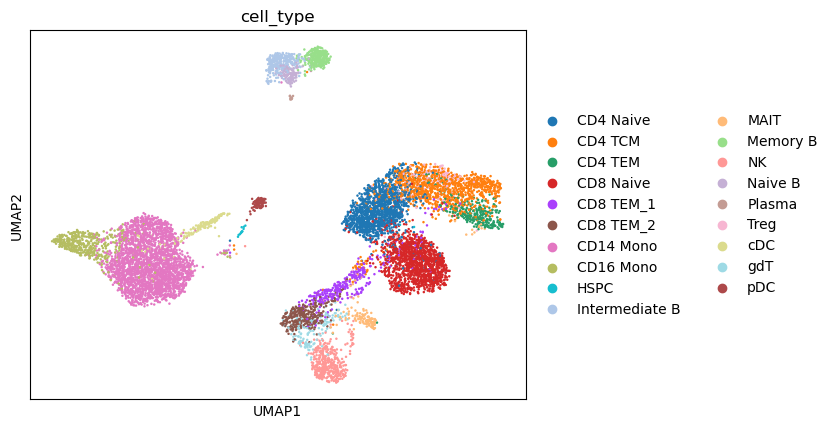

In [18]:
# Plot UMAP using scanpy module
sc.pl.umap(adata_atac, color=['cell_type'])


In [20]:
# Look at UMAP of protein latent space..
Z = adata_atac.obsm['z']

# Turn them into AnnData objects and take the observation names from the individual AnnData objects
atac_latent_adata = anndata.AnnData(Z, obs=adata_atac.obs)


In [21]:
# Look at UMAP of the latent space for the scATAC encoder (Z2).
sc.tl.pca(atac_latent_adata)
sc.pp.neighbors(atac_latent_adata)
sc.tl.umap(atac_latent_adata)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


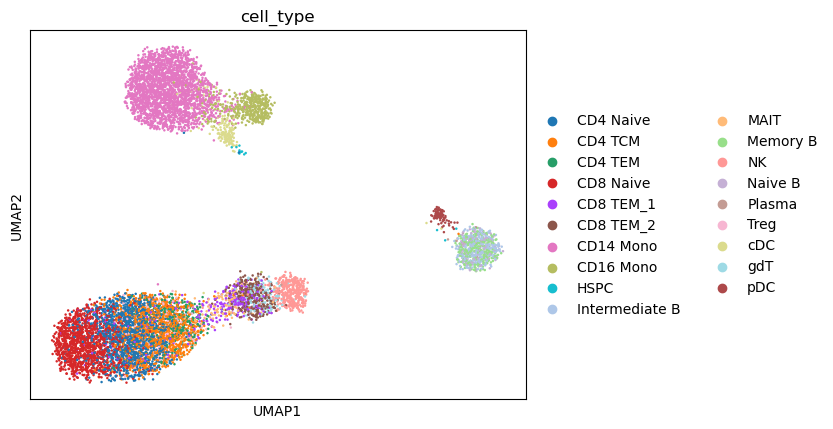

In [22]:
# Visualize UMAP using the scanpy module
sc.pl.umap(atac_latent_adata, color=['cell_type'])


In [27]:
# Look at UMAP of both RNA raw data and RNA latent data on its own..
# Look at UMAP of RNA data on its own..
sc.tl.pca(adata_rna)
sc.pp.neighbors(adata_rna)
sc.tl.umap(adata_rna)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


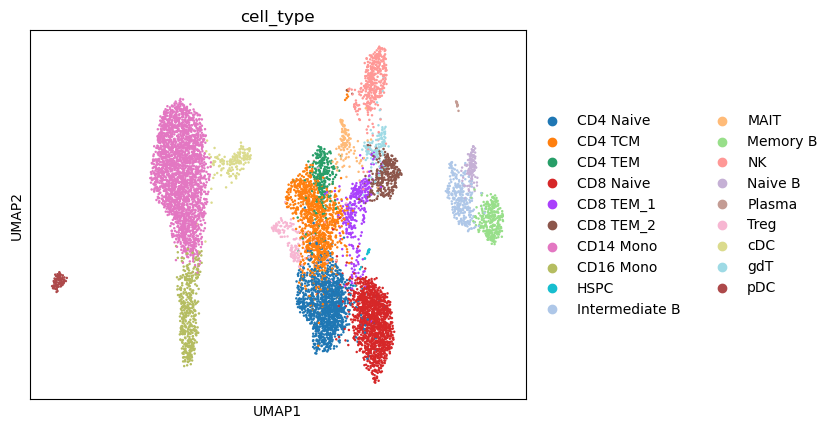

In [28]:
sc.pl.umap(adata_rna, color=['cell_type'])


In [29]:
# Look at UMAP of protein latent space..
Z = adata_rna.obsm['z']

# Turn them into AnnData objects and take the observation names from the individual AnnData objects
rna_latent_adata = anndata.AnnData(Z, obs=adata_rna.obs)


In [30]:
# Look at UMAP of RNA data latent space..
sc.tl.pca(rna_latent_adata)
sc.pp.neighbors(rna_latent_adata)
sc.tl.umap(rna_latent_adata)


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


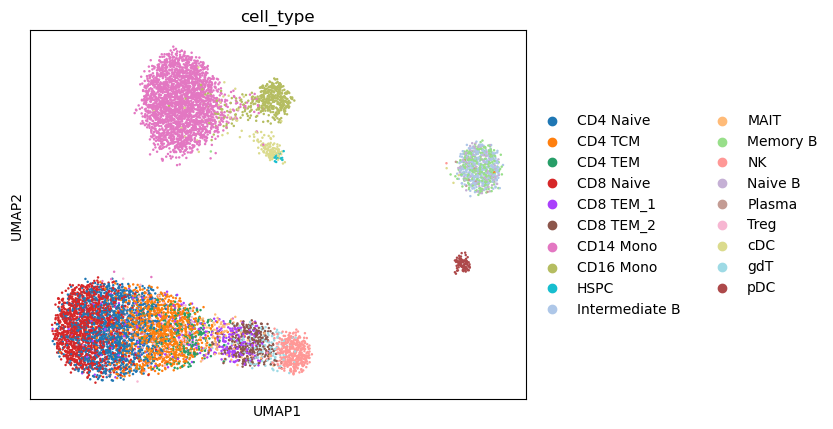

In [31]:
sc.pl.umap(rna_latent_adata, color=['cell_type'])


## Look at combined latent space

In [32]:
# Can generate a UMAP of the combined-modality objects like so, and look at the data prior to model integration..
sc.tl.pca(inputs_concat)
sc.pp.neighbors(inputs_concat)
sc.tl.umap(inputs_concat)

# NOTE: Again, this can take a while depending on cell counts..


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


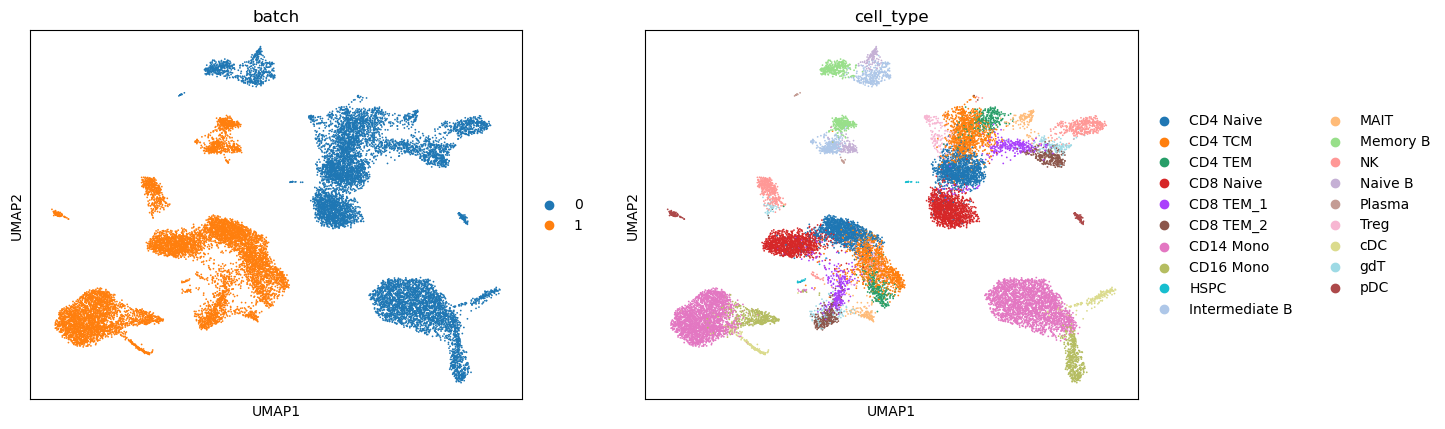

In [33]:
# Can visualize the UMAP space prior to model integration like so..
sc.pl.umap(inputs_concat, color=['batch', 'cell_type'])


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


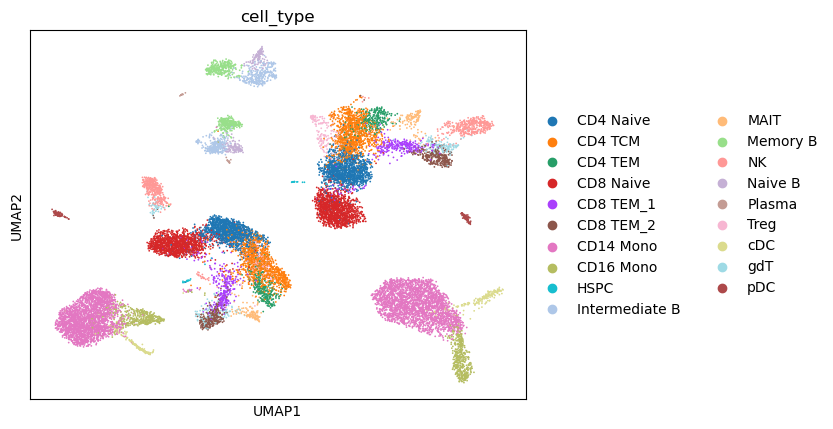

In [34]:
sc.pl.umap(inputs_concat, color=['cell_type'])


Now, we can combine the data to view it all on a UMAP, for instance by doing the following:

In [35]:
# Update to best epoch prior to making the lower dimensional UMAP?
trained_model_obj.update_to_best_epoch()



* Loading the best model state from epoch 142


In [36]:
# Read in both modalities to the same AnnData object with a built-in function.
adata_both = trained_model_obj.get_anndata_pair()

# NOTE: This can take a while as the cell counts are higher..


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


In [37]:
# The concatenated version should keep many of the features from each object individually, but adata_both.X 
# in this case are the sampled latent features.
#print(adata_both) 

# Note that the dimensions are cell quantity in the object which should be doubled since it contains both the
# modalities concatenated to one another. The second dimension (50 in this case), are the latent dimensions

#print(adata_both.obsp['distances'])
#print(adata_both.obsp['connectivities'])


In [38]:
# Can generate a UMAP of the combined-modality objects like so, and look at the latent data after model integration..
sc.tl.umap(adata_both)

# NOTE: This step can also take a while depending on how many cells there are in your data
# To speed this process up while you're learning, it might be good to use a subset sample of cells to speed the
# computation.


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


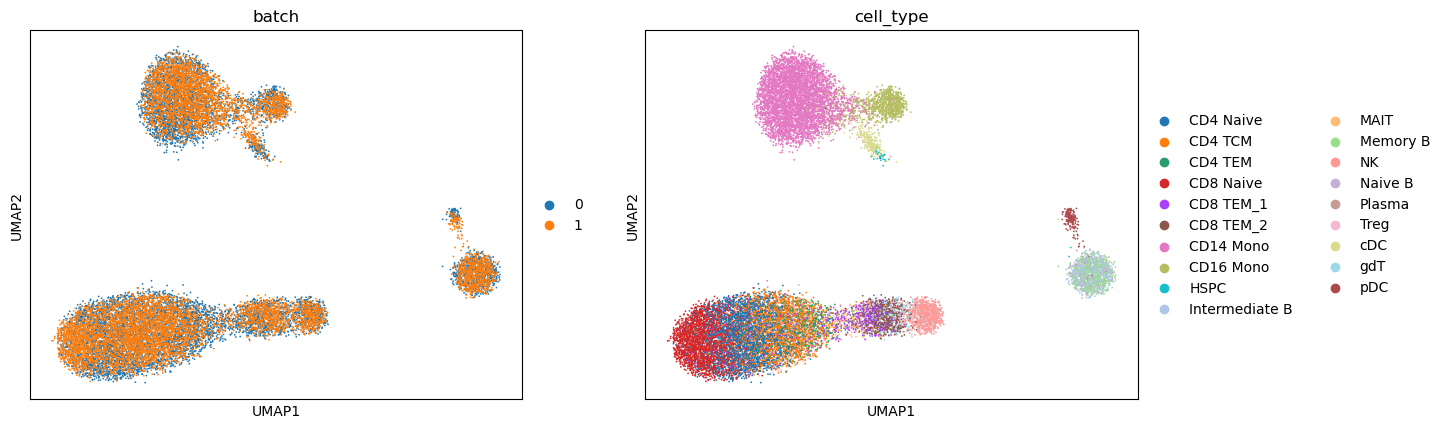

In [40]:
# Can color the UMAP by different categories from the AnnData object and view it like so:
sc.pl.umap(adata_both, color=['batch', 'cell_type']) 

# NOTE: This is looking at a low-dimensional representation of all the latent feature distributions between modalities


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


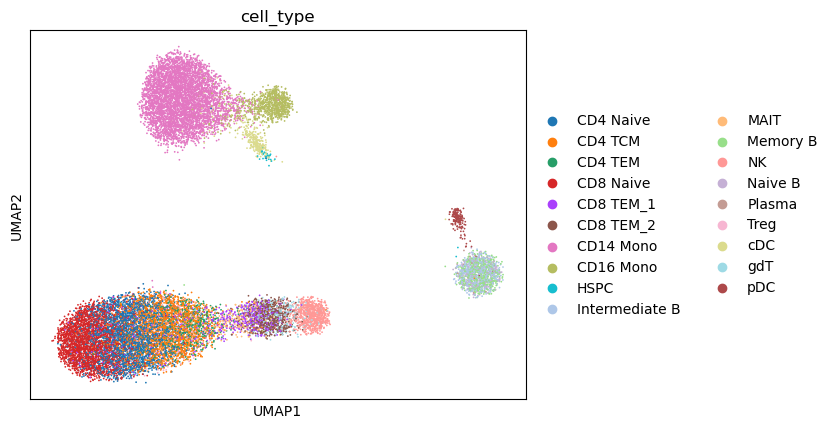

In [41]:
sc.pl.umap(adata_both, color=['cell_type'])

In [42]:
print(adata_both)

AnnData object with n_obs × n_vars = 18874 × 60
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch'
    uns: 'neighbors', 'umap', 'batch_colors', 'cell_type_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'


At the risk of getting in the weeds a little bit, here is how to access the distribution spaces in the model for both the output distributions and the latent feature distributions.

In [44]:
# For this step it's very important that we update to the best-scoring epoch, because we will be accessing 
# the distribution spaces from this training epoch.
trained_model_obj.update_to_best_epoch()

# This is helpful when recreating data or using raw latent/high dimensioanal distributions.
# The next step automatically uses the best epoch since it's built into the model, but I wanted to show a different
# way of updating to the best epoch.

# NOTE: Each epoch contains "feature size" x "batch size" sized values. For instance, qzxs below contains a batch
# size of 500 and a latent dimension size of 60. The decoder variable contains 500 batch size x 2000 features used
# since the output is recreating the 2000 input features.



* Loading the best model state from epoch 142


In [45]:
# Load individual parts of the model, starting with "qzxs", the encoder distribution space:
qzxs = trained_model_obj.dic_best_samples['qzxs']

# This is built into the crossmap object, and many different aspects of this epoch of the model can be accessed
# by using the cm.dic_best_samples variable.. I'll you how to access a few parts of model from its best training
# epoch.



* Loading the best model state from epoch 142

- FOSCTTM of PBMC_multiome_batch_size_500_p30_multi_gaussian_z60_l3_l5_m_elbo_mc20_b145_m1_dim_hidden_224_m2_dim_hidden_224_m1_features_2000_m2_features_2000: 0.22


In [46]:
# Look at contents of qzxs variable
print(qzxs)


[Normal(loc: torch.Size([500, 60]), scale: torch.Size([500, 60])), Normal(loc: torch.Size([500, 60]), scale: torch.Size([500, 60]))]


In [47]:
print(qzxs[0])

Normal(loc: torch.Size([500, 60]), scale: torch.Size([500, 60]))


In [48]:
# To explore the encoder distributions, you can manipulate the variable like so:
# To access modality 1 latent dimension means and standard deviations:
m1_mean = qzxs[0].loc # Gets the mean of the tensor encoder latent space for each distribution for modality 1
m1_std = qzxs[0].scale # Gets the std of the tensor encoder latent space for each distribution for modality 1

# There are many different ways to interact with these distribution tensor spaces, might want to look at tensor
# documentation for any questions.


In [49]:
# Print the contents of modality 1's latent feature distribution space:
# Notice how the contents of these variables are tensor distribution objects..
print(m1_mean)
print(m1_std)


tensor([[ 0.1384, -0.9882,  1.5027,  ..., -1.7022,  0.8493,  0.0637],
        [-0.0799,  0.0183,  0.1431,  ...,  0.3433,  0.0071, -0.0680],
        [-0.0638,  0.2004,  0.1403,  ..., -0.4658,  0.1469,  0.1343],
        ...,
        [ 0.1039, -0.2335, -0.0328,  ...,  0.0538, -0.2099,  0.1123],
        [ 0.0203, -0.3267, -0.0143,  ...,  0.1356, -0.0809,  0.1184],
        [ 0.1366, -0.1510, -0.0145,  ...,  0.1516, -0.0918,  0.2117]],
       grad_fn=<AddmmBackward0>)
tensor([[2.0074, 1.4308, 1.3261,  ..., 1.4302, 1.6132, 1.3318],
        [1.7464, 1.7401, 1.6918,  ..., 1.6039, 1.4815, 1.4852],
        [1.8526, 1.8342, 1.5684,  ..., 1.6461, 1.4812, 1.3948],
        ...,
        [1.5492, 1.5762, 1.4953,  ..., 1.4535, 1.3599, 1.3601],
        [1.6927, 1.5718, 1.6383,  ..., 1.5128, 1.4776, 1.4762],
        [1.5934, 1.5923, 1.5618,  ..., 1.5029, 1.4126, 1.3928]],
       grad_fn=<AddBackward0>)


In [50]:
# To access modality 2 latent dimension means and standard deviations:
m2_mean = qzxs[1].loc # The mean of each of the latent distributions for modality 2
m2_std = qzxs[1].scale # The std of each of the latent distributions for modality 2


In [51]:
# Print the contents of modality 2's latent feature distribution space:
print(m2_mean)
print(m2_std)


tensor([[ 0.0223, -0.5915,  1.0949,  ..., -1.2587,  0.2001, -0.2304],
        [-0.1041,  0.0716,  0.0777,  ...,  0.0990,  0.0226,  0.0804],
        [-0.0872,  0.2159,  0.1066,  ..., -0.2855, -0.1043, -0.2761],
        ...,
        [-0.1243, -0.1837, -0.0185,  ..., -0.0143, -0.2467,  0.0660],
        [-0.4687, -0.1016, -0.0020,  ..., -0.1393, -0.0796,  0.1221],
        [-0.0931, -0.1217,  0.0529,  ..., -0.0911, -0.1475,  0.0632]],
       grad_fn=<AddmmBackward0>)
tensor([[1.7128, 1.5591, 1.4753,  ..., 1.4186, 1.6004, 1.5497],
        [1.6520, 1.9893, 1.7587,  ..., 1.7116, 1.4931, 1.5028],
        [1.7615, 1.8643, 1.6380,  ..., 1.6693, 1.4060, 1.8241],
        ...,
        [1.5702, 1.5417, 1.4832,  ..., 1.5019, 1.3448, 1.3995],
        [1.6759, 1.5526, 1.5058,  ..., 1.5970, 1.4402, 1.4231],
        [1.5860, 1.5107, 1.4614,  ..., 1.5197, 1.3897, 1.4446]],
       grad_fn=<AddBackward0>)


In [52]:
# To sample from these distributions, you can do something like the following:
num_samples = 1000
samples1 = qzxs[0].sample((num_samples,))
samples2 = qzxs[1].sample((num_samples,))

# This outputs tensor objects housing your samples from the latent distributions
print(samples1)
print(samples1.shape)

print(samples2)
print(samples2.shape)


tensor([[[ 0.1843, -0.4674, -1.9971,  ..., -2.8324,  1.6710, -0.9734],
         [ 0.4556,  2.9551,  1.3015,  ..., -0.7790,  1.0902, -0.6515],
         [ 0.5890, -0.2038,  1.9963,  ..., -2.1147,  1.1512,  0.8228],
         ...,
         [-1.7709,  0.9255, -3.2478,  ..., -0.6879,  0.9717, -0.5546],
         [-0.7573, -0.1607, -0.4497,  ..., -0.3207,  0.5531, -1.2337],
         [ 0.5820,  0.5900,  4.4157,  ..., -0.2374,  0.6810, -0.2127]],

        [[ 0.7753,  0.9942,  2.4382,  ..., -2.2051,  0.6240,  0.6660],
         [-3.4534,  0.4258, -0.5740,  ...,  1.4874, -3.4413,  1.0345],
         [-1.1436, -0.6996, -0.2138,  ..., -1.2994,  0.8305,  0.5030],
         ...,
         [ 0.1730,  0.1935, -1.0875,  ...,  0.7312, -2.1779,  0.5066],
         [ 1.1907,  1.2199, -0.9635,  ..., -0.9540,  1.3002, -0.9911],
         [-0.9213, -0.1969, -0.9621,  ..., -1.8692,  1.3141,  1.5462]],

        [[-0.2411, -1.9535, -1.0113,  ...,  1.1464, -0.1137, -1.7925],
         [ 0.9954,  2.4121,  0.1731,  ...,  2

In [53]:
# We can use this same concept to access pxzs - the output distributions from the method (the reconstructed data
# from the best scoring epoch)
pxzs = trained_model_obj.dic_best_samples['pxzs']


In [54]:
print(pxzs)


[[Normal(loc: torch.Size([500, 2000]), scale: torch.Size([500, 2000])), Normal(loc: torch.Size([500, 2000]), scale: torch.Size([500, 2000]))], [Normal(loc: torch.Size([500, 2000]), scale: torch.Size([500, 2000])), Normal(loc: torch.Size([500, 2000]), scale: torch.Size([500, 2000]))]]


In [55]:
# In addition to the following parts of the model:
# The input samples (I think) from this epoch
xs = trained_model_obj.dic_best_samples['xs']

# Latent space samples from the best epoch
zss = trained_model_obj.dic_best_samples['zss']

# The UMAP coordinates of the latent space from this epoch
es = trained_model_obj.dic_best_samples['es']


In [56]:
print(xs)
print(zss)
print(es)


[genes                   HES4     ISG15  TNFRSF18    TNFRSF4     AJAP1  \
TCCGGTTTCCTAAGAC-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
CTCCCTGAGTTCCCGT-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
GGTTTCCTCGTTACAA-1  5.935191  1.308385 -0.146306  -0.148254 -0.051454   
CGATTCCTCGTTAAGC-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
TGATTGCAGCTCATAA-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
...                      ...       ...       ...        ...       ...   
GTTTGTTTCATGGCCA-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
ACCAGGGAGCGCCTTT-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
TAGTGAGAGTTTGGGT-1 -0.188851 -0.526863 -0.146306  10.000000 -0.051454   
TAGGGTTTCCAGCACA-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
AATAGAGGTTAATCGG-1 -0.188851  1.353986 -0.146306  -0.148254 -0.051454   

genes               AL365255.1    SLC2A5  TNFRSF1B  AL357873.1  AL031283.2  \
TCCGGTTTCCTAAGAC-1   -0.078636 -0.062656 -0.

## Generating data using the trained model

You can also generate your own data using the method, I'll show you how to do that in the following section.

In [57]:
# To create cross-modal data, you should start with an input of the same features used to train the model.
# For example, if you used RNA-seq data to train the model and 2000 RNA features, you'll want to restrict the
# input features to this subset of genes. You'll also want to make sure the data is transformed in the same
# way the original training input data was. In this case, the data is usually transformed into a Z-score. If you
# want to look more into the built-in data preprocessing steps, see the scripts at the following locations:
# /scvt/scvt/datasets/_anndata.py, specifically the PrepAnndataRNA and PrepAnndataADT functions.

# We'll want to start with some input data, X. In our case this will be 2000 RNA-seq features used to train the
# model.
rna_input_data = adata_rna.X


In [58]:
# Randomly sample, say, 500 samples from this data (this is generally bad form since the model has already likely
# seen this data, but for this example lets not worry about that..)

# Set a random seed for reproducibility
np.random.seed(42)

# Randomly select 500 samples
random_rna_samples = rna_input_data[np.random.choice(rna_input_data.shape[0], 15000, replace=True)]

# Make sure it contains 500 samples and the right number of features (2000 in this case)
print(random_rna_samples.shape)


(15000, 2000)


In [59]:
# Now that we have our data to generate cross-modal data from, we need to apply it to the model like so:
generated_data = trained_model_obj.reconstruct(random_rna_samples, 'm1') # Need to specify 'm1' to recreate using modality 1 or 2's latent space

# Resulting data is 'xp', or self-reconstructed, and 'xpp', or cross-reconstructed
#generated_rna_data = generated_data['xp']
generated_atac_data = generated_data['xpp']

print(generated_atac_data)
print(generated_atac_data.shape)

# Now we have 500 generated samples of 2000 features of the cross-modal ATAC data using RNA-seq as an input.


For first modality
[[ 0.0558807  -0.33313692 -0.2990822  ... -0.00256953 -0.24893421
  -0.08318087]
 [ 0.02696373 -0.33207276 -0.3037967  ... -0.00525654 -0.22409531
  -0.05253066]
 [ 0.02995232  0.07468803 -0.2017635  ... -0.02619733 -0.13641524
  -0.14933209]
 ...
 [ 0.03876581  0.0764074  -0.20629571 ... -0.02645666 -0.139012
  -0.15105782]
 [-0.14126071 -0.03739475  0.55651224 ... -0.01428713  0.473768
  -0.12035729]
 [ 0.592668   -0.2980326  -0.37199455 ... -0.00740401 -0.20526312
  -0.00677785]]
(15000, 2000)


Now, in order to generate specific cell-types, we can use the encoder to encode the latent representation of specific cells, then use that encoding on the decoder, and sample from the decoded space.. we can do this for any number of samples.

In [60]:
# Using our RNA-seq sample data with 500 randomly selected samples, we can also do the following:
# Get the latent feature representations of the data..
rna_to_rna_latent = pd.DataFrame(trained_model_obj.get_latent_features(random_rna_samples, 'm1')) # Specify m1 or m2 to recreate data using latent space 1 or 2. In this case, 1 is RNA data
rna_to_atac_latent = pd.DataFrame(trained_model_obj.get_latent_features(random_rna_samples, 'm2'))


x in first modality
x in first modality


In [61]:
# Look at the rna_to_atac_latent variable
print(rna_to_atac_latent)


             0         1         2         3         4         5         6   \
0     -1.449615 -1.905416  1.862481  1.098696  0.106071 -1.754140 -0.735501   
1      1.915432  1.391539  1.446632 -2.766611 -1.609941  1.678992 -1.175428   
2     -0.302007  0.549606  0.657659  1.202671  0.969495 -0.088037 -0.402437   
3     -0.034374 -2.243298 -2.928699 -2.185585 -0.636547  0.817682 -0.179996   
4     -0.431609 -0.123375 -2.060204  0.057663 -2.155302  0.378494 -0.388298   
...         ...       ...       ...       ...       ...       ...       ...   
14995  1.786500 -1.511096 -1.013240  0.922998  0.989117 -0.437592 -1.444259   
14996 -1.455373 -2.643389  2.739443  0.818046  0.517642 -1.675799 -0.123326   
14997 -1.303274  0.222453 -0.706042 -1.589168 -0.085289  1.984055  0.412429   
14998  0.834324 -2.100143 -0.735828 -0.211196  0.379319  1.616623 -0.918626   
14999 -0.139346 -2.900460  0.970223 -0.249813  0.917121 -0.398186 -4.240508   

             7         8         9   ...        50 

In [62]:
# We can then use these latent representations of the data to generate any number of new samples using the decoder..
# Reconstruct aka decode the latent features:
reconstructed_data_from_latent_dim_1 = trained_model_obj.recon_from_z1(rna_to_rna_latent)

# Use recon_from_z1 when reconstructing data from latent dimension 1, ie the RNA's encoder.. 
# then use either [0] to access reconstructed RNA data or [1] to access reconstructed ATAC data.
# Can use recon_from_z2 when you have the opposite modality latent information.. access the reconstructed
# with [0] for self modality or [1] for cross-modality.

# Reconstructed RNA data from Z1
print(reconstructed_data_from_latent_dim_1[0])

# Reconstructed ATAC data from Z1
print(reconstructed_data_from_latent_dim_1[1])


           HES4     ISG15  TNFRSF18   TNFRSF4     AJAP1  AL365255.1    SLC2A5  \
0     -0.098722 -0.124631 -0.093781 -0.098235 -0.021770   -0.044801 -0.029930   
1     -0.085723 -0.076149 -0.119255 -0.116687 -0.019388   -0.043652 -0.029144   
2     -0.150747 -0.107920 -0.175165 -0.158865 -0.044997    0.117729 -0.028604   
3      0.746203  0.430575 -0.103746 -0.113666 -0.032167   -0.036466 -0.046809   
4     -0.169148 -0.025440 -0.043107 -0.019399 -0.058881    0.063287 -0.002932   
...         ...       ...       ...       ...       ...         ...       ...   
14995 -0.146218 -0.031500  0.259621  0.479532 -0.035148    0.028320 -0.024324   
14996 -0.151838 -0.092334 -0.158514 -0.142394 -0.043031    0.107806 -0.031124   
14997 -0.146057 -0.085085 -0.148886 -0.139836 -0.038534    0.101637 -0.035161   
14998  0.000468  0.146218  0.595237  0.076665 -0.054760   -0.027633 -0.031833   
14999  0.994159  0.488649 -0.110731 -0.132908 -0.040535   -0.032533 -0.049349   

       TNFRSF1B  AL357873.1

In [64]:
# I haven't covered it here, but to generate entirely new data, you could encode specific cell types, then 
# sample from those encodings until you have the desired number of created samples.
# For whatever reason, the "cm.generate()" function isn't currently working properly, so to generate data, we'd

from UniVI.utilities._utils import data_to_device, Logger, Timer, dic2obj, dic_params_print, tensor_to_df, tensor_to_numpy, df_to_tensor, get_device, embed_umap, embed_tsne, embed_pca, kl_divergence, check_mtx_to_df, lst_unique_from_dic, Lists

z1 = df_to_tensor(rna_to_rna_latent)

print(z1)
print(z1.shape)

xg11, xg12 = trained_model_obj.model.recon_from_z1(z1)

print(xg11)
print(xg11.shape)

#df_xg11 = tensor_to_df(xg11, index=df_z1.index, columns=self.adata1.var.index.tolist())
#df_xg12 = tensor_to_df(xg12, index=df_z1.index, columns=self.adata2.var.index.tolist())


tensor([[-1.2762,  0.6734, -0.2545,  ...,  1.1765,  2.8115,  2.3171],
        [-0.4515, -1.5856, -0.4002,  ..., -3.1069,  1.8216, -1.1866],
        [ 0.4678, -0.5355, -1.0519,  ...,  2.4150,  0.2047, -0.6879],
        ...,
        [ 1.6021, -0.2448,  3.4852,  ...,  2.1650,  0.1921,  3.3560],
        [-0.0056, -0.7123,  1.5391,  ..., -3.3785,  0.9368, -0.9808],
        [-2.4924,  4.7910,  1.4920,  ..., -0.4393,  0.8563,  0.6527]])
torch.Size([15000, 60])
tensor([[-9.8722e-02, -1.2463e-01, -9.3781e-02,  ..., -1.3080e-02,
         -4.1657e-02,  6.0734e-01],
        [-8.5723e-02, -7.6149e-02, -1.1926e-01,  ..., -8.6301e-03,
         -3.8324e-02,  7.2717e-01],
        [-1.5075e-01, -1.0792e-01, -1.7517e-01,  ...,  6.2704e-02,
         -3.8000e-02, -4.5437e-01],
        ...,
        [-1.4606e-01, -8.5085e-02, -1.4889e-01,  ...,  4.4555e-02,
         -3.6773e-02, -4.5743e-01],
        [ 4.6843e-04,  1.4622e-01,  5.9524e-01,  ..., -2.5613e-02,
         -3.0776e-02, -8.0921e-02],
        [ 9.94

In [65]:
# Can look at the entire contents of the CrossMap trained model object like so..
print(vars(trained_model_obj))


{'_epoch_current': 172, '_dic_best_samples': {'xs': [genes                   HES4     ISG15  TNFRSF18    TNFRSF4     AJAP1  \
TCCGGTTTCCTAAGAC-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
CTCCCTGAGTTCCCGT-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
GGTTTCCTCGTTACAA-1  5.935191  1.308385 -0.146306  -0.148254 -0.051454   
CGATTCCTCGTTAAGC-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
TGATTGCAGCTCATAA-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
...                      ...       ...       ...        ...       ...   
GTTTGTTTCATGGCCA-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
ACCAGGGAGCGCCTTT-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
TAGTGAGAGTTTGGGT-1 -0.188851 -0.526863 -0.146306  10.000000 -0.051454   
TAGGGTTTCCAGCACA-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
AATAGAGGTTAATCGG-1 -0.188851  1.353986 -0.146306  -0.148254 -0.051454   

genes               AL365255.1    SLC2A5  TNFRSF1B  AL357873.1  AL0312

## Experimenting a bit with data generation..

In [67]:
adata_rna_df = pd.DataFrame(adata_rna.X)
x1 = df_to_tensor(adata_rna_df)

adata_atac_df = pd.DataFrame(adata_atac.X)
x2 = df_to_tensor(adata_atac_df)

print(x1)
print(x2)

#cm.model.reconstruct(x1, x2)


tensor([[-0.1889,  0.5770, -0.1463,  ..., -0.0533, -0.0195, -0.3915],
        [-0.1889,  0.0786, -0.1463,  ..., -0.0533, -0.0195, -0.9451],
        [-0.1889,  2.5474, -0.1463,  ..., -0.0533, -0.0195, -0.7376],
        ...,
        [-0.1889, -0.5269, -0.1463,  ..., -0.0533, -0.0195, -0.4449],
        [-0.1889,  0.8718, -0.1463,  ..., -0.0533, -0.0195, -1.2363],
        [-0.1889,  0.3972, -0.1463,  ..., -0.0533, -0.0195, -0.9062]])
tensor([[-0.7242, -0.3691, -0.4581,  ..., -0.0349, -0.5334, -0.1691],
        [ 4.3693, -0.3691, -0.4581,  ..., -0.0349,  0.7279, -0.1691],
        [-0.7242, -0.3691, -0.4581,  ..., -0.0349, -0.5334, -0.1691],
        ...,
        [-0.7242, -0.3691, -0.4581,  ..., -0.0349, -0.5334, -0.1691],
        [-0.7242, -0.3691,  0.7794,  ..., -0.0349, -0.5334, -0.1691],
        [ 0.7743, -0.3691, -0.4581,  ..., -0.0349,  0.3941, -0.1691]])


In [68]:
qzxs, pxzs, zss = trained_model_obj.model([x1, x2])

print(pxzs)


[[Normal(loc: torch.Size([9437, 2000]), scale: torch.Size([9437, 2000])), Normal(loc: torch.Size([9437, 2000]), scale: torch.Size([9437, 2000]))], [Normal(loc: torch.Size([9437, 2000]), scale: torch.Size([9437, 2000])), Normal(loc: torch.Size([9437, 2000]), scale: torch.Size([9437, 2000]))]]


In [71]:
from torch import distributions as dist

# If you recall, we're using our randomly selected samples from earlier to generate both an RNA and an ATAC
# latent dimensional representation:

# Randomly select 15000 samples
#random_rna_samples = rna_input_data[np.random.choice(rna_input_data.shape[0], 15000, replace=True)]

# Then we did:
#rna_to_rna_latent = pd.DataFrame(cm.get_latent_features(random_rna_samples, 'm1')) # Specify m1 or m2 to recreate data using latent space 1 or 2. In this case, 1 is RNA data
#rna_to_atac_latent = pd.DataFrame(cm.get_latent_features(random_rna_samples, 'm2'))

#print(rna_to_rna_latent)
#print(rna_to_atac_latent)

# Can do the following for just one latent dimension representation of a sample
#z1 = df_to_tensor(rna_to_rna_latent.loc[[0]]) # or..
z1 = df_to_tensor(rna_to_rna_latent)
z2 = df_to_tensor(rna_to_atac_latent)

print("\n")
print("z1 tensor generated from randomly selected samples with replacement from input RNA-seq data (Z-scores): ")
print(z1)
print("\n")

pxz1 = trained_model_obj.model1._get_pxz(z1)
pxz2 = trained_model_obj.model2._get_pxz(z2)

print("\n")
print("pxz1 from cm.model1._get_pxz(z1) function: ")
print(pxz1)
print("\n")

# To sample from the latent space multiple times and recreate the data:
#num_samples = 550
#xg = pxz.sample((num_samples,))

# To only sample from the latent space once and recreate the data:
xg1 = pxz1.sample()
xg2 = pxz2.sample()

print("\nOriginal input RNA data: ")
print(df_to_tensor(pd.DataFrame(adata_rna.X)))
print("\n")

print("\nModel 1 data generation from input latent dimensions: ")
print(xg1)
print(xg1.shape)
print("\n")

print("\nModel 2 data generation from input latent dimensions: ")
print(xg2)
print(xg2.shape)
print("\n")




z1 tensor generated from randomly selected samples with replacement from input RNA-seq data (Z-scores): 
tensor([[-1.2762,  0.6734, -0.2545,  ...,  1.1765,  2.8115,  2.3171],
        [-0.4515, -1.5856, -0.4002,  ..., -3.1069,  1.8216, -1.1866],
        [ 0.4678, -0.5355, -1.0519,  ...,  2.4150,  0.2047, -0.6879],
        ...,
        [ 1.6021, -0.2448,  3.4852,  ...,  2.1650,  0.1921,  3.3560],
        [-0.0056, -0.7123,  1.5391,  ..., -3.3785,  0.9368, -0.9808],
        [-2.4924,  4.7910,  1.4920,  ..., -0.4393,  0.8563,  0.6527]])




pxz1 from cm.model1._get_pxz(z1) function: 
Normal(loc: torch.Size([15000, 2000]), scale: torch.Size([15000, 2000]))



Original input RNA data: 
tensor([[-0.1889,  0.5770, -0.1463,  ..., -0.0533, -0.0195, -0.3915],
        [-0.1889,  0.0786, -0.1463,  ..., -0.0533, -0.0195, -0.9451],
        [-0.1889,  2.5474, -0.1463,  ..., -0.0533, -0.0195, -0.7376],
        ...,
        [-0.1889, -0.5269, -0.1463,  ..., -0.0533, -0.0195, -0.4449],
        [-0.1889

### Next, work through built-in CrossMap object functions from the workflow script and fix broken code as we go 5-1-2024

In [15]:
print(trained_model_obj)


In [17]:
dic_best_samples = trained_model_obj.dic_best_samples
print(dic_best_samples)


{'xs': [genes                   HES4     ISG15  TNFRSF18    TNFRSF4     AJAP1  \
TCCGGTTTCCTAAGAC-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
CTCCCTGAGTTCCCGT-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
GGTTTCCTCGTTACAA-1  5.935191  1.308385 -0.146306  -0.148254 -0.051454   
CGATTCCTCGTTAAGC-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
TGATTGCAGCTCATAA-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
...                      ...       ...       ...        ...       ...   
GTTTGTTTCATGGCCA-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
ACCAGGGAGCGCCTTT-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
TAGTGAGAGTTTGGGT-1 -0.188851 -0.526863 -0.146306  10.000000 -0.051454   
TAGGGTTTCCAGCACA-1 -0.188851 -0.526863 -0.146306  -0.148254 -0.051454   
AATAGAGGTTAATCGG-1 -0.188851  1.353986 -0.146306  -0.148254 -0.051454   

genes               AL365255.1    SLC2A5  TNFRSF1B  AL357873.1  AL031283.2  \
TCCGGTTTCCTAAGAC-1   -0.078636 -0.062

In [34]:
adata1 = trained_model_obj.adata1
adata2 = trained_model_obj.adata2


In [30]:
# Tried to run "CrossMap_object.degs_unique" - gave the following assertion error:
# AssertionError: no key defined in adata1.obs: ident, run first add_ident_to_adata

# First, run add_ident_to_adata before running CrossMap_object.degs_unique. 
#trained_model_obj.add_ident_to_adata

# Need to add ident to adata1 and adata2.obs.. not to entire CrossMap_object
#print(trained_model_obj.add_ident_to_adata) # THIS DOESN'T WORK 5/8/2024

# Can't find the "add_ident_to_adata" function anywhere. Might need to add it or include it..
# Could do it like so:
trained_model_obj.adata1.obs['ident'] = trained_model_obj.adata1.obs['cell_type']
trained_model_obj.adata2.obs['ident'] = trained_model_obj.adata2.obs['cell_type']


In [38]:
# The below function doesn't work because it can't find adata.uns['log1p']['base']
print(adata1)
print(adata1.uns['log1p'])
print(adata1.layers['lib_normed_log1p'])

print(adata2)
print(adata2.uns['log1p'])
print(adata2.layers['lib_normed_log1p'])


AnnData object with n_obs × n_vars = 9437 × 2000
    obs: 'domain', 'protocol', 'dataset', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.8', 'seurat_clusters', 'sub.cluster', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'ident'
    var: 'gene_ids', 'feature_types', 'genome', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_type', 'gene_name', 'hgnc_id', 'havana_gene', 'tag', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'umap', 'deg_test'
    obsm: 'X_umap', 'Z', 'Z_umap', 'z'
    layers: 'counts', 'lib_normed_log1p', 'z_scaled'
    obsp: 'connectivities'

In [41]:
import numpy as np

# Adding base to adata.uns['log1p']['base'].. assumed to be the natural log for this operation.
# Might need to go through and add it to the log1p calculation code - Can't find it for some reason?
# The code that's calling the functions are in:
# UniVI/datasets/_anndata.py
trained_model_obj.adata1.uns['log1p']['base'] = np.e
trained_model_obj.adata2.uns['log1p']['base'] = np.e


In [42]:
# This function only works after adding the following to each AnnData object in the trained model object:
#trained_model_obj.adata1.uns['log1p']['base'] = np.e
#trained_model_obj.adata2.uns['log1p']['base'] = np.e

degs_unique = trained_model_obj.degs_unique
print(degs_unique)


Running DEG Test using 'z_scaled', 'ident', 'wilcoxon' saved in slot 'deg_test'


/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/groups/precepts/ashforda/anac

(['FHIT', 'LEF1', 'CAMK4', 'BACH2', 'ANK3', 'INPP4B', 'MLLT3', 'TXK', 'CD247', 'IL7R', 'ITGB1', 'IL32', 'LTB', 'SYNE2', 'RORA', 'GPRIN3', 'BCL2', 'S100A4', 'PDE3B', 'NELL2', 'THEMIS', 'CD8B', 'APBA2', 'CD8A', 'CCL5', 'GZMK', 'IFNG-AS1', 'KLRK1', 'A2M', 'SAMD3', 'NKG7', 'DUSP2', 'GZMH', 'GNLY', 'GZMA', 'PRF1', 'TGFBR3', 'PFN1', 'DPYD', 'PLXDC2', 'NEAT1', 'LRMDA', 'ARHGAP26', 'FCN1', 'VCAN', 'SLC8A1', 'JAK2', 'NAMPT', 'TCF7L2', 'PSAP', 'IFITM3', 'AIF1', 'LST1', 'MTSS1', 'FCGR3A', 'CST3', 'COTL1', 'SERPINA1', 'SOX4', 'NKAIN2', 'CDK6', 'STMN1', 'ERG', 'ZNF521', 'MAP7', 'CASC15', 'AUTS2', 'ST8SIA6', 'RALGPS2', 'BANK1', 'MS4A1', 'OSBPL10', 'AFF3', 'CD79A', 'PAX5', 'CD74', 'BLK', 'EBF1', 'SLC4A10', 'PHACTR2', 'KLRB1', 'ZBTB16', 'IGHM', 'FCRL1', 'IGHD', 'LINC00926', 'KLRD1', 'MCTP2', 'CTSW', 'KLRF1', 'CST7', 'SEL1L3', 'HLA-DRA', 'TXNDC5', 'MZB1', 'TNFRSF17', 'DERL3', 'PPIB', 'ITM2C', 'HSP90B1', 'SSR4', 'PDIA4', 'FKBP11', 'IKZF2', 'RTKN2', 'IL2RA', 'TOX', 'PLCL1', 'LINC02694', 'HLA-DRB1', 'HLA-

/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/groups/precepts/ashforda/anaconda3/envs/UniVI_working_environment_v2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
/home/groups/precepts/ashforda/anac

In [43]:
dic_degs = trained_model_obj.dic_degs
print(dic_degs)


({'CD4 Naive': ['FHIT', 'LEF1', 'CAMK4', 'BACH2', 'ANK3', 'INPP4B', 'MLLT3', 'TXK', 'CD247', 'IL7R'], 'CD4 TCM': ['INPP4B', 'ANK3', 'ITGB1', 'IL32', 'IL7R', 'LTB', 'SYNE2', 'RORA', 'GPRIN3', 'CAMK4'], 'CD4 TEM': ['LTB', 'RORA', 'IL7R', 'IL32', 'ITGB1', 'BCL2', 'S100A4', 'INPP4B', 'SYNE2', 'ANK3'], 'CD8 Naive': ['PDE3B', 'LEF1', 'NELL2', 'BACH2', 'THEMIS', 'CD8B', 'TXK', 'CAMK4', 'APBA2', 'CD8A'], 'CD8 TEM_1': ['CCL5', 'IL32', 'SYNE2', 'GZMK', 'IFNG-AS1', 'KLRK1', 'A2M', 'SAMD3', 'NKG7', 'DUSP2'], 'CD8 TEM_2': ['CCL5', 'NKG7', 'GZMH', 'GNLY', 'GZMA', 'PRF1', 'IL32', 'TGFBR3', 'A2M', 'PFN1'], 'CD14 Mono': ['DPYD', 'PLXDC2', 'NEAT1', 'LRMDA', 'ARHGAP26', 'FCN1', 'VCAN', 'SLC8A1', 'JAK2', 'NAMPT'], 'CD16 Mono': ['TCF7L2', 'PSAP', 'IFITM3', 'AIF1', 'LST1', 'MTSS1', 'FCGR3A', 'CST3', 'COTL1', 'SERPINA1'], 'HSPC': ['SOX4', 'NKAIN2', 'CDK6', 'STMN1', 'ERG', 'ZNF521', 'MAP7', 'CASC15', 'AUTS2', 'ST8SIA6'], 'Intermediate B': ['RALGPS2', 'BANK1', 'MS4A1', 'OSBPL10', 'AFF3', 'CD79A', 'PAX5', 'CD74

#### Notes to this point

Up to this point, I've had to add several items to the trained model object. These include adding the AnnData.obs['ident'] copying over from AnnData.obs['cell_type'] for both AnnData objects (adata1 and adata2) within the trained model object. I also had to add AnnData.uns['log1p']['base'] = np.e since we used the log1p, the base is the natural number - e. 

#### Next, we will continue down the CrossMap class and test each function

In [48]:
# NOTE: Below functions need to be called with parentheses
saved_model = trained_model_obj.save()
print(saved_model)


None


In [57]:
latent_embedding_adata2 = trained_model_obj.embed(trained_model_obj.adata2.X)
print(latent_embedding_adata2)


[[11.120525   5.3772492]
 [10.712893   4.24906  ]
 [11.484327   5.359465 ]
 ...
 [12.272863   1.6869061]
 [11.275844   4.1228676]
 [11.026266   4.49481  ]]
